位移/路程 重构动量因子 均值

In [1]:
import polars as pl
import numpy as np

# 读取数据
data = pl.read_parquet("hourly_data.pa")

df = data.sort('open_time').sort('symbol')

# 定义窗口大小
window_size = 15

# 计算每个symbol每时刻的价格差
df = df.with_columns([
    pl.col("close").diff().abs().over("symbol").alias("price_diff"),
    (pl.col('close') / (pl.col('close').shift(1).over('symbol')) - 1).alias('return')
])

# 计算价格变化
df = df.with_columns([
    (pl.col("close") - pl.col("close").shift(window_size)).over("symbol").alias("price_change")
])

# 计算绝对价格变化的总和
df = df.with_columns([
    pl.col("price_diff").rolling_sum(window_size, min_periods=window_size).over("symbol").alias("abs_price_change_sum")
])

# 计算价格位移与路程之比因子
df = df.with_columns([
    (pl.col("price_change") / pl.col("abs_price_change_sum")).alias("momentum_factor")
])

df


open_time,open,high,low,close,volume,close_time,quote_volume,count,taker_buy_volume,taker_buy_quote_volume,symbol,price_diff,return,price_change,abs_price_change_sum,momentum_factor
datetime[μs],f64,f64,f64,f64,f64,datetime[μs],f64,i64,f64,f64,str,f64,f64,f64,f64,f64
2022-09-09 13:00:00,0.4728,0.4874,0.3663,0.451,6.5705837e7,2022-09-09 13:59:59.999,2.8487e7,124200,3.3701922e7,1.4632e7,"""1000LUNCUSDT""",null,null,null,null,null
2022-09-09 14:00:00,0.451,0.4609,0.4277,0.4592,4.1316126e7,2022-09-09 14:59:59.999,1.8355e7,94104,2.0298138e7,9.0220e6,"""1000LUNCUSDT""",0.0082,0.018182,null,null,null
2022-09-09 15:00:00,0.4594,0.4734,0.4416,0.4555,4.4134479e7,2022-09-09 15:59:59.999,2.0198e7,103417,2.2353913e7,1.0239e7,"""1000LUNCUSDT""",0.0037,-0.008057,null,null,null
2022-09-09 16:00:00,0.4554,0.458,0.4175,0.4297,4.6242265e7,2022-09-09 16:59:59.999,2.0187e7,84951,2.1467246e7,9.3760e6,"""1000LUNCUSDT""",0.0258,-0.056641,null,null,null
2022-09-09 17:00:00,0.4297,0.4418,0.4071,0.4156,2.661109e7,2022-09-09 17:59:59.999,1.1376e7,50896,1.2655405e7,5.4132e6,"""1000LUNCUSDT""",0.0141,-0.032814,null,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2022-12-31 19:00:00,0.1494,0.1498,0.1494,0.1496,748908.5,2022-12-31 19:59:59.999,112011.25443,882,481198.1,71987.20389,"""ZRXUSDT""",0.0002,0.001339,-0.0012,0.0038,-0.315789
2022-12-31 20:00:00,0.1496,0.1497,0.1494,0.1496,501195.0,2022-12-31 20:59:59.999,74979.34106,751,282290.8,42242.69096,"""ZRXUSDT""",0.0,0.0,-0.0006,0.0032,-0.1875
2022-12-31 21:00:00,0.1496,0.1497,0.149,0.149,413737.4,2022-12-31 21:59:59.999,61817.02306,583,132775.7,19839.82814,"""ZRXUSDT""",0.0006,-0.004011,-0.0011,0.0037,-0.297297


In [2]:
# 计算相关系数的滚动均值并加入原始结果中
result_df = df.with_columns([
    pl.col("momentum_factor").rolling_mean(20).alias("mean_momentum_factor")
])

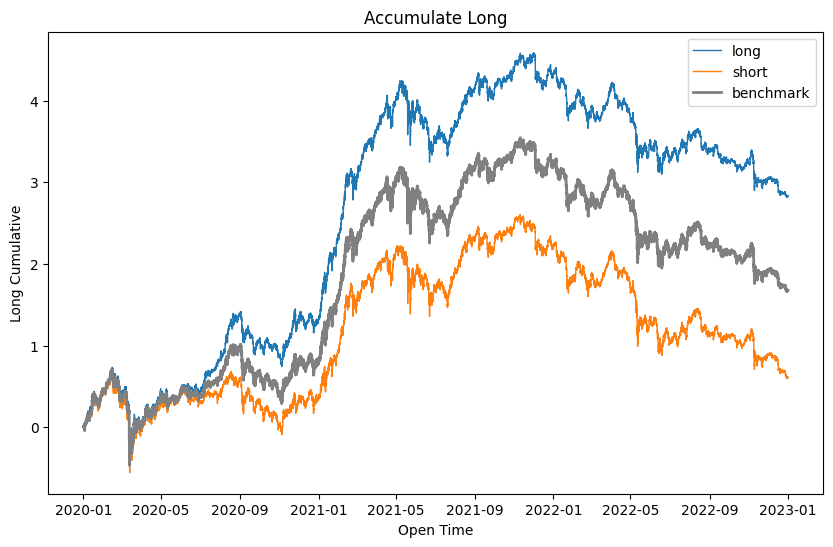

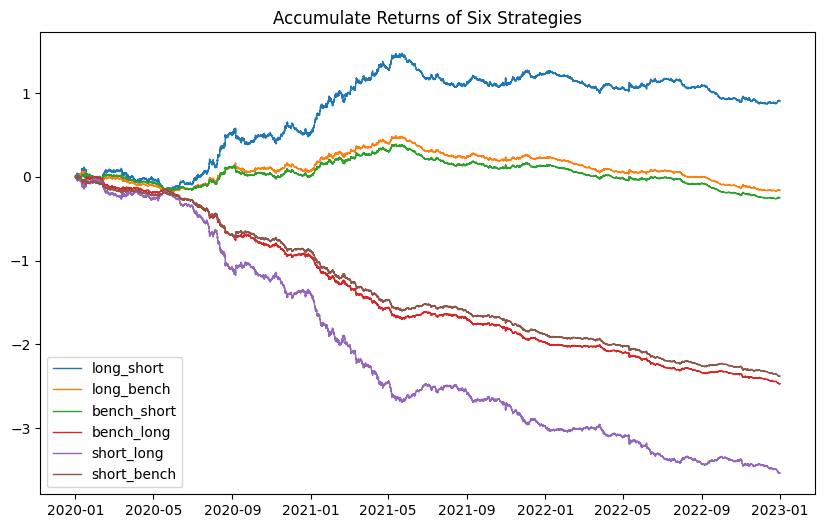

long: 
ann_return = 0.9424  sharpe = 0.8569  maxdd = 0.663  calmar_ratio = 1.4216  

short: 
ann_return = 0.2028  sharpe = 0.1854  maxdd = 0.7309  calmar_ratio = 0.2775  

bench: 
ann_return = 0.5575  sharpe = 0.513  maxdd = 0.6895  calmar_ratio = 0.8085  

long_short: 
ann_return = 0.3016  sharpe = 0.9776  maxdd = 0.2507  calmar_ratio = 1.2028  

long_bench: 
ann_return = -0.0531  sharpe = -0.3363  maxdd = 0.4431  calmar_ratio = -0.1198  

bench_long: 
ann_return = -0.8229  sharpe = -5.2141  maxdd = 2.4473  calmar_ratio = -0.3363  

short_long: 
ann_return = -1.1776  sharpe = -3.8169  maxdd = 3.5127  calmar_ratio = -0.3352  

short_bench: 
ann_return = -0.7927  sharpe = -5.0679  maxdd = 2.3702  calmar_ratio = -0.3344  

bench_short: 
ann_return = -0.0833  sharpe = -0.5327  maxdd = 0.469  calmar_ratio = -0.1776  



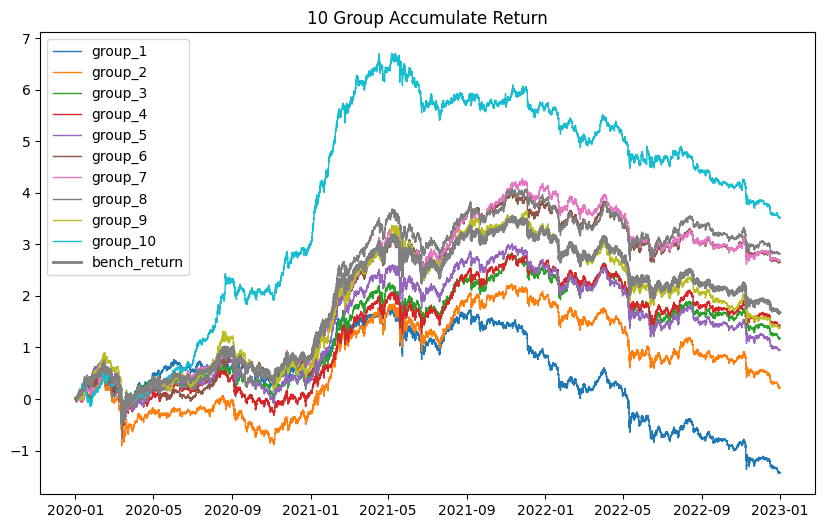

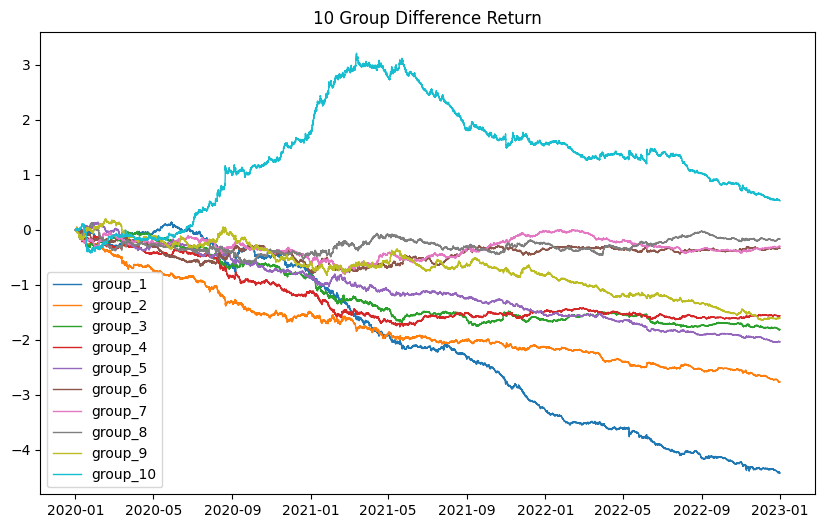

group_1: 
ann_return = -0.4778  sharpe = -0.4035  maxdd = 1.1578  calmar_ratio = -0.4126  

group_2: 
ann_return = 0.0742  sharpe = 0.0659  maxdd = 0.9353  calmar_ratio = 0.0793  

group_3: 
ann_return = 0.3911  sharpe = 0.3488  maxdd = 0.6904  calmar_ratio = 0.5665  

group_4: 
ann_return = 0.4745  sharpe = 0.4291  maxdd = 0.8174  calmar_ratio = 0.5805  

group_5: 
ann_return = 0.3166  sharpe = 0.285  maxdd = 0.7247  calmar_ratio = 0.4368  

group_6: 
ann_return = 0.8829  sharpe = 0.7917  maxdd = 0.6971  calmar_ratio = 1.2666  

group_7: 
ann_return = 0.8942  sharpe = 0.7954  maxdd = 0.7265  calmar_ratio = 1.231  

group_8: 
ann_return = 0.9386  sharpe = 0.8201  maxdd = 0.8475  calmar_ratio = 1.1075  

group_9: 
ann_return = 0.4605  sharpe = 0.3978  maxdd = 0.6507  calmar_ratio = 0.7076  

group_10: 
ann_return = 1.171  sharpe = 0.943  maxdd = 0.654  calmar_ratio = 1.7905  

-----------------------------------------
group_difference_1: 
ann_return = -1.4733  sharpe = -3.6195  maxdd = 

In [3]:
factors = result_df.select(['open_time', 'symbol', 'mean_momentum_factor'])

from factor_analysis.factor_analysis import FactorAnalysis

# 使用示例
analysis = FactorAnalysis(factors, data)
analysis.run_full_analysis()